# **Sales Forecasting System**

**Problem Statement:**

Our company plan to expand by setting up a new warehouse in a new location. We need to estimate future sales to ensure that the new facility is appropriately sized and stocked. Historical sales data indicates a consistent increase since the company’s inception.

The objective of this project is to develop a sales forecasting system that will be able to predict the rate of sales for the upcoming months. These forecasts will help in:

- Determining the optimal warehouse space required.

- Planning inventory levels to meet expected demand.

- Reducing storage costs and avoiding stockouts.

The system is base in historical sales data to identify trends, seasonality, and patterns, and generate reliable predictions that support strategic business decisions for warehouse planning and inventory management.

###  **Importing Libraries**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from pickle import dump

In [2]:
# Load dataset directly from the URL
total_data = pd.read_csv("https://breathecode.herokuapp.com/asset/internal-link?id=2545&path=sales.csv")

# Inspect the dataset
total_data.head(3)

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693


In [3]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [4]:
# Convert date column to datetime
total_data['date'] = pd.to_datetime(total_data['date'])

# Set date as index
total_data.set_index('date', inplace=True)

# Crate a sales variable
sales = total_data["sales"]

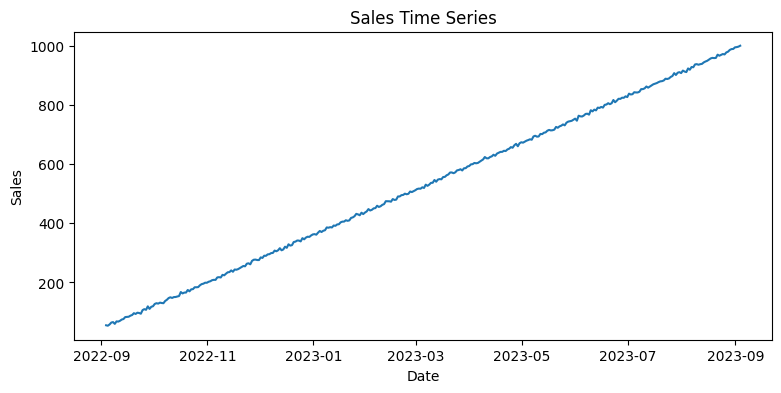

In [5]:
# Plot the time series
plt.figure(figsize=(9,4))
sns.lineplot(total_data['sales'])
plt.title('Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

#### **Analysis of a time series**

**Decomposition of the series**

In [ ]:
decomposition = seasonal_decompose(total_data, period = 12)
decomposition

**Trend analysis**

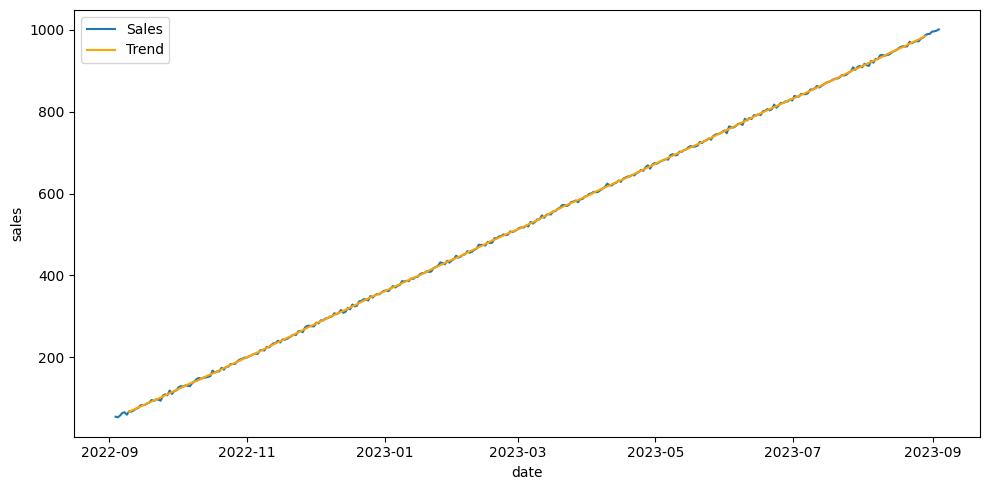

In [7]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales , label = 'Sales')
sns.lineplot(data = trend , label = 'Trend', color = 'orange')

plt.tight_layout()

plt.show()

- This confirms what has been observed: a clear positive trend on sales overtime.

**Seasonality analysis**

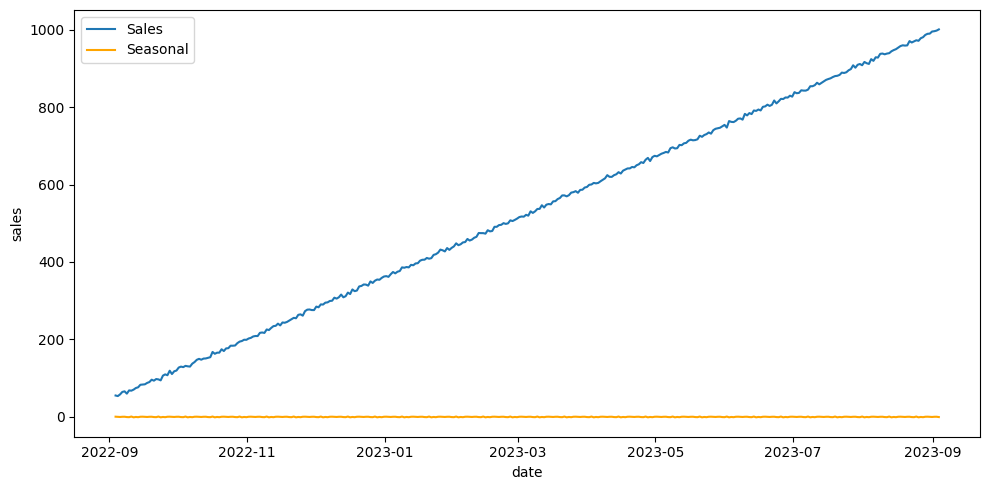

In [8]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales , label = 'Sales')
sns.lineplot(data = seasonal, label = 'Seasonal', color = 'orange')

plt.tight_layout()

plt.show()

In [9]:
# Evaluate the stationarity with Dickey-Fuller test
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(sales)

Dickey-Fuller test results:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

-  The null hypothesis is that the series is stationary, and the alternative is that it is non-stationary.

    Here we can see that the p-value is greater than 0.05, which means that our null hypothesis will be rejected, and we will take this series as non-stationary.

**Analysis of variability**

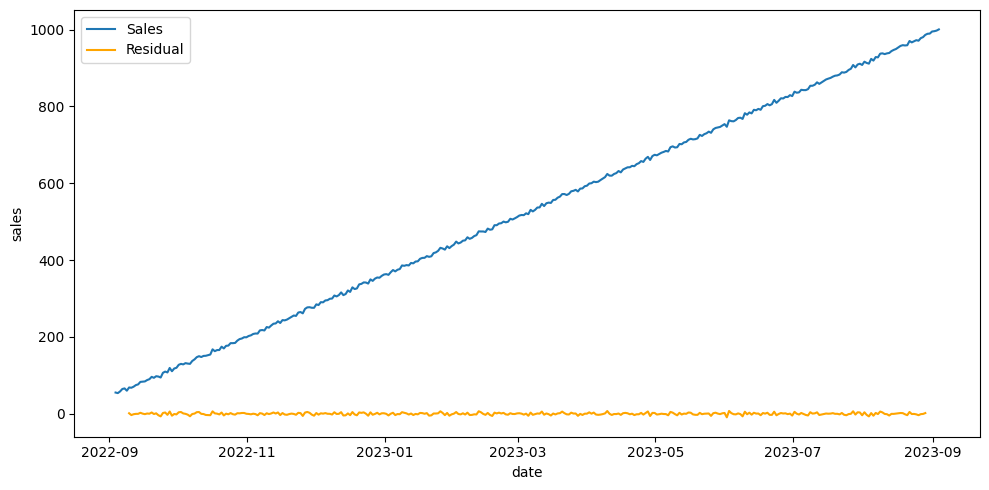

In [10]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales, label = 'Sales')
sns.lineplot(data = residual,   label = 'Residual', color = 'orange')

plt.tight_layout()

plt.show()

- The time series shows a very small residual variability, indicating that most of the pattern is explained by the trend and seasonality.

#### **Machine Learning**

**ARIMA Model**

In [ ]:
# Make the time series stationary by differencing
data_stationary = sales.diff().dropna()

test_stationarity(data_stationary)

Dickey-Fuller test results:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [ ]:
# Fit the ARIMA model
model = auto_arima(data_stationary, seasonal = True, trace = False, m = 12)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Sun, 24 Aug 2025   AIC                           1839.553
Time:                        19:35:55   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Forecast the next 12 months
forecast = model.predict(12)
forecast

2023-09-04 17:10:08.079328    1.675366
2023-09-05 17:10:08.079328    2.673520
2023-09-06 17:10:08.079328    2.591621
2023-09-07 17:10:08.079328    2.598341
2023-09-08 17:10:08.079328    2.597789
2023-09-09 17:10:08.079328    2.597834
2023-09-10 17:10:08.079328    2.597831
2023-09-11 17:10:08.079328    2.597831
2023-09-12 17:10:08.079328    2.597831
2023-09-13 17:10:08.079328    2.597831
2023-09-14 17:10:08.079328    2.597831
2023-09-15 17:10:08.079328    2.597831
Freq: D, dtype: float64

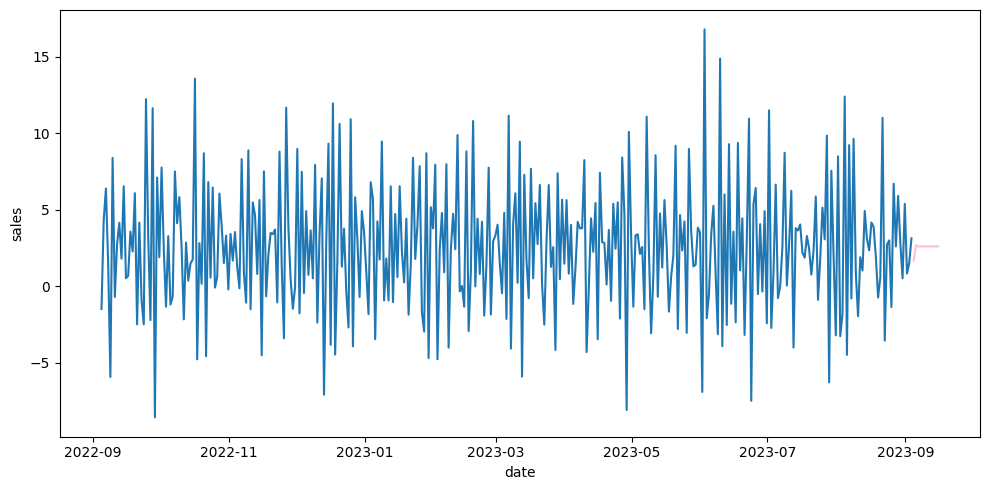

In [ ]:
# Plot the forecast
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = data_stationary)
sns.lineplot(data = forecast, c = "pink")

plt.tight_layout()

plt.show()

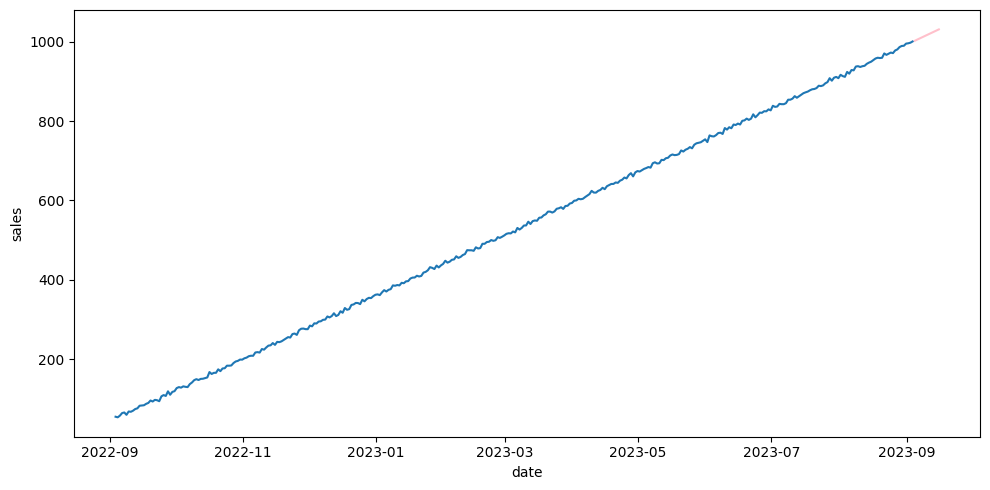

In [ ]:
# Convert the differenced forecast back to the original scale
last_level = sales.iloc[-1]
pred_level = forecast.cumsum() + last_level

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales)
sns.lineplot(data = pred_level, c = "pink")

plt.tight_layout()

plt.show()

**Save the model**

In [47]:
dump(model, open("../models/timeseries_model.sav", "wb"))

___